# BERT base neuralmind, soma dos score do par.

## ontoPT-validation
- (1,1) é um par onde hipônimo e hiperônimo são de tamanho 1
- O tamanho do par (1,1) será 2, assim como o tamanho do par (2,1) e (1,2) será 3

> Suponha o par (3,2) (abacate, fruta)
> Temos as seguintes sentenças:
- [MASK] ca te é um tipo de fru ta
- aba [MASK] te é um tipo de fru ta
- aba ca [MASK] é um tipo de fru ta
- aba ca te é um tipo de [MASK] ta
- aba ca te é um tipo de fru [MASK]

> Mascarando a palavra e pegando o score dela. O score pra esse par será a soma de todos os valores recuperados.

## Usando wikipedia240M para comparação
 - Sem OOV = 42800 pares
 - com OOV = 94446 pares
 
 



In [9]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import os

sns.set(style="whitegrid")
plt.clf()
method_names = {'word2vec': 'Word2vec C', 'summation_dot_product': 'DIVE \u0394S * C ', 'dot_product': 'DIVE C',
                'rnd': 'random', 'summation': 'DIVE \u0394S', 'summation_word2vec': 'DIVE \u0394S * Word2vec C',
                'all_subword mean_positional_rank': 'BERT Mean Pos Rank', 'all_subword min_positional_rank': 'BERT Min Pos Rank',
                'all_subword max_pattern': 'BERT Max Pattern', 'all_subword mean_pattern': 'BERT Mean Pattern',
                'min score_final_log(z)': 'BERT Min Pos Rank (log(z))', 'min score_final_norm': 'BERT Min Pos Rank (/ norm)',
                'mean score_final_log(z)': 'BERT Mean Pos Rank (log(z))', 'mean score_final_norm': 'BERT Mean Pos Rank (/ norm)'}

def create_dataframe(json_dict):
    dict_values = {'hiponimo': [], 'hiperonimo':[], 'classe':[], 'fonte':[], 'pattern': [], 'soma_hipo':[], 'soma_hiper':[], 'len_hipo':[], 'len_hiper':[]}
    for data, values in json_dict.items():
        hipo, hiper, classe, fonte = data.strip().split()
        for pattern, score in values.items():
            dict_values['hiponimo'].append(hipo)
            dict_values['hiperonimo'].append(hiper)
            dict_values['classe'].append(classe)
            dict_values['fonte'].append(fonte)
            dict_values['pattern'].append(pattern)
            soma = sum(score[0])
            dict_values['soma_hipo'].append(soma)
            soma = sum(score[1])
            dict_values['soma_hiper'].append(soma)
            dict_values['len_hipo'].append(len(score[0]))
            dict_values['len_hiper'].append(len(score[1]))

    df = pd.DataFrame(dict_values)
    df['bert_soma_total'] = df['soma_hipo'] + df['soma_hiper']
    df['len_total'] = df['len_hipo'] + df['len_hiper']
    return df


def filter_by_vocab(path_vocab, dict_data):
    wiki_name = path_vocab.split("/")[-2][9:]
    new_data = {}
    vocab = []
    for line in open(path_vocab):
        w, c = line.strip().split()
        vocab.append(w)
    vocab = set(vocab)

    for k, v in dict_data.items():
        hipo, hyper, _, _ = k.strip().split()
        if hipo in vocab and hyper in vocab:
            new_data[k] = v.copy()
    return new_data


# verificar balanceamento True/False
def balanceamento(df, len_size):
    df_rate = df[df['pattern'] == pattern_unique[0]][['hiponimo', 'hiperonimo', 'classe', 'fonte', 'len_total']]
    df_rate = df_rate.groupby(['len_total'])['classe'].value_counts()

    dict_values = {'len_total': [], 'true':[], 'false':[]}
    for v in len_size:
        if v in df_rate:
            dict_values['len_total'].append(v)
            if "True" in df_rate[v]:
                dict_values['true'].append(df_rate[v]['True'])
            else:
                dict_values['true'].append(0)
            if "False" in df_rate[v]:
                dict_values['false'].append(df_rate[v]['False'])
            else:
                dict_values['false'].append(0)
        else:
            print(f"Balanceamento: {v} não está no dataframe!")

    df_taxa = pd.DataFrame(dict_values)
    # return df_taxa
    df_taxa['ratio'] = df_taxa['true'] / (df_taxa['true'] + df_taxa['false'])
    return df_taxa


#logsumexp para cada tamanho subtoken e normalização
def logsumexp_normalization(df_data, len_list, pattern_list):
    df = df_data.copy()
    log_store = {}
    logsumexp_store = {}
    normalization = {}
    for size in len_list:
        log_store[size] = {}
        logsumexp_store[size] = {}
        normalization[size] = {}
        for p in pattern_list:
            if p in log_store:
                raise ValueError
            values = df[(df.pattern == p) & (df.len_total == size)]
            log_store[size][p] = torch.tensor(values['bert_soma_total'].tolist())
            logsumexp_store[size][p] = torch.logsumexp(log_store[size][p], dim=0)
            normalization[size][p] = torch.sum(log_store[size][p])

    df['log(Z)'] = df.apply(lambda row: logsumexp_store[row['len_total']][row['pattern']].item(), axis=1)
    df['sum_bert_by_tokensize'] = df.apply(lambda row: normalization[row['len_total']][row['pattern']].item(), axis=1)
    return df


def compute_dataframe_AP_by_pattern(df, key_sort, pattern_list):
    ap_by_pattern = {}
    for p in pattern_list:
        prec_list = []
        df_sorted = df[df['pattern'] == p]
        df_sorted = df_sorted.sort_values(by=key_sort, ascending=False)
        hyper_num = 0
        total_pair = 0
        for row in df_sorted.itertuples():
            total_pair += 1
            if row.fonte == 'hyper':
                hyper_num += 1
                prec_list.append(hyper_num / float(total_pair))

        ap_by_pattern[p] = np.mean(prec_list)
    return pd.DataFrame(data={'padrao': pattern_unique, 'AP': list(ap_by_pattern.values())})


# compute ap in sorted list
def compute_AP(sorted_list):
    prec_list = []
    hyper_num = 0
    total_pair = 0
    for row in sorted_list:
        total_pair += 1
        hyper = row[0].strip().split()[3]
        if hyper == 'hyper':
            hyper_num += 1
            prec_list.append(hyper_num / float(total_pair))
    return np.mean(prec_list)


def compute_AP_by_rank(df, key_sort, best_patterns):
    rank = {}
    # compute rank
    for p in best_patterns:
        df_sorted = df[df['pattern'] == p]
        df_sorted = df_sorted.sort_values(by=key_sort, ascending=False, ignore_index=True)
        for row in df_sorted.itertuples():
            name  = f"{row.hiponimo} {row.hiperonimo} {row.classe} {row.fonte}"
            if name in rank:
                rank[name].append(row.Index)
            else:
                rank[name] = []
                rank[name].append(row.Index)

    mean_rank = {}
    for row in rank:
        if row in mean_rank:
            raise ValueError
        mean_rank[row] = np.mean(rank[row])

    min_rank = {}
    for row in rank:
        if row in min_rank:
            raise ValueError
        min_rank[row] = min(rank[row])
    del rank
    sort_mean_rank = sorted(mean_rank.items(), key=lambda x: x[1])
    sort_min_rank = sorted(min_rank.items(), key=lambda x: x[1])
    del mean_rank, min_rank
    mean_ap = compute_AP(sort_mean_rank)
    min_ap = compute_AP(sort_min_rank)

    return min_ap, mean_ap


def compute_AP_n_best_pattern(df, key_sort, n_best_pattern):
    dict_values = {'n_best_pattern': [], 'method': [] ,'AP':[]}
    for num_p in range(1, len(n_best_pattern) + 1):
        min_ap, mean_ap = compute_AP_by_rank(df=df, key_sort=key_sort, best_patterns=n_best_pattern[:num_p])
        dict_values['n_best_pattern'].append(num_p)
        dict_values['method'].append('min ' + key_sort)
        dict_values['AP'].append(min_ap)
        dict_values['n_best_pattern'].append(num_p)
        dict_values['method'].append('mean ' + key_sort)
        dict_values['AP'].append(mean_ap)
    return pd.DataFrame(dict_values)

vocabs = ["../vocabs/wikipedia15M/vocab.txt",
          "../vocabs/wikipedia30M/vocab.txt",
          "../vocabs/wikipedia60M/vocab.txt",
          "../vocabs/wikipedia120M/vocab.txt",
          "../vocabs/wikipedia240M/vocab.txt"]
# path_d_w = ["/home/gabrielescobar/Documentos/dive-pytorch/results/wikipedia-datasets-test/wikipedia240M_W10_neg15_e15_lr1e-03_eps1e-08_emb100_batch128_runX_not_oov/_result_models_model-wikipedia240M_W10_neg15_e15_lr1e-03_eps1e-08_emb100_batch128_runX_dataset_.-datasets.tsv",
#             "/home/gabrielescobar/Documentos/dive-pytorch/results/wikipedia-datasets-test/wikipedia240M_W10_neg15_e15_lr1e-03_eps1e-08_emb100_batch128_runX/_result_models_model-wikipedia240M_W10_neg15_e15_lr1e-03_eps1e-08_emb100_batch128_runX_dataset_.-datasets.tsv"]

# data
#server
path_file_bert = "/home/gabrielescobar/hyper_bert/teste/neuralmind-bert-base-portuguese-cased_bert-score_n-subtoken/ontoPT-validation.json"

# path_file_bert = "../aaaaaaaa/test_neuralmind-bert-base-portuguese-cased/TESTE2.json"
# path_file_bert = "../teste/neuralmind-bert-base-portuguese-cased_bert-score_n-subtoken/conceptnet-hypernym-1.json"

json_data = json.load(open(path_file_bert))

df_240 = create_dataframe(filter_by_vocab(vocabs[4], json_data))
df_with_oov = create_dataframe(json_data)


pattern_unique = df_with_oov['pattern'].unique().tolist()
len_total_unique = df_with_oov['len_total'].unique().tolist()

print(f"DF 240 = {df_240[df_240['pattern'] == pattern_unique[0]].count()['hiponimo']}")
print(f"DF all with OOV = {df_with_oov[df_with_oov['pattern'] == pattern_unique[0]].count()['hiponimo']}")

# df com oov
df_with_oov = logsumexp_normalization(df_with_oov, len_list=len_total_unique, pattern_list=pattern_unique)
#score final soma_total - log(Z)
df_with_oov['score_final_log(z)'] = df_with_oov['bert_soma_total'] - df_with_oov['log(Z)']
df_with_oov['score_final_norm'] = df_with_oov['bert_soma_total'] / df_with_oov['sum_bert_by_tokensize']

# df 240M sem oov
df_240 = logsumexp_normalization(df_240, len_list=len_total_unique, pattern_list=pattern_unique)
#score final soma_total - log(Z)
df_240['score_final_log(z)'] = df_240['bert_soma_total'] - df_240['log(Z)']
df_240['score_final_norm'] = df_240['bert_soma_total'] / df_240['sum_bert_by_tokensize']

DF 240 = 42800
DF all with OOV = 94446


<Figure size 432x288 with 0 Axes>

## Balanceamento do Dataset e AP por padrão
#### Wikipedia 240M sem OOV
 - N = 42800 pares

Balanceamento: 12 não está no dataframe!
Balanceamento: 11 não está no dataframe!


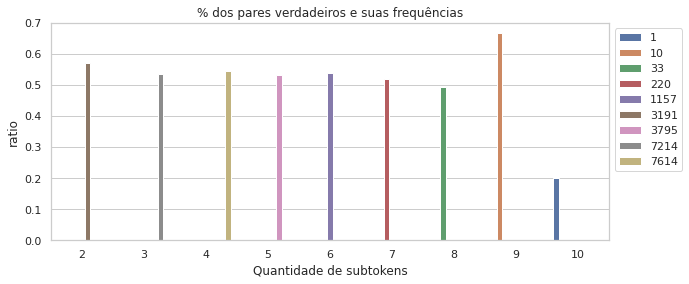

In [10]:
# Balanceamento df_240M
df_240_ratio = balanceamento(df_240, len_size=len_total_unique)

plt.figure(figsize=(10, 4))
ax = sns.barplot(x="len_total", y="ratio", hue="true", data=df_240_ratio)
ax.set(xlabel="Quantidade de subtokens")
ax.set_title(f"% dos pares verdadeiros e suas frequências")
ax.legend(bbox_to_anchor=(1, 1))

_ = _

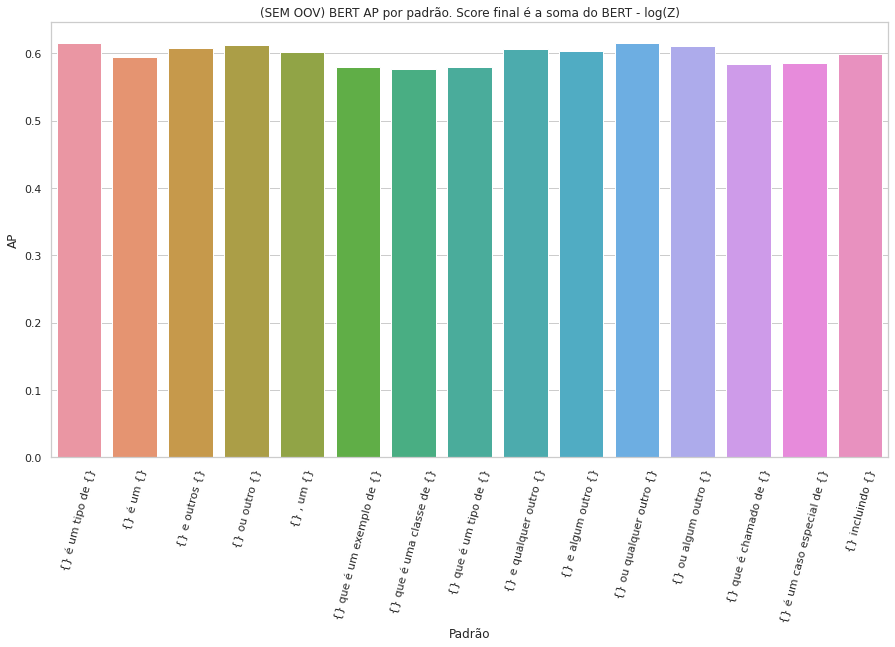

Melhores padrões usando score_final_log(Z)
['{} ou qualquer outro {}', '{} é um tipo de {}', '{} ou outro {}', '{} ou algum outro {}', '{} e outros {}', '{} e qualquer outro {}', '{} e algum outro {}', '{} , um {}', '{} incluindo {}', '{} é um {}', '{} é um caso especial de {}', '{} que é chamado de {}', '{} que é um tipo de {}', '{} que é um exemplo de {}', '{} que é uma classe de {}']


In [11]:
# AP por padrão
df_plot = compute_dataframe_AP_by_pattern(df_240, key_sort="score_final_log(z)", pattern_list=pattern_unique)
plt.figure(figsize=(15, 8))
ax = sns.barplot(data=df_plot, x='padrao', y='AP')
ax.set(xlabel="Padrão")
ax.set_title(f"(SEM OOV) BERT AP por padrão. Score final é a soma do BERT - log(Z)")
plt.xticks(rotation=75)
plt.show()

print(f"Melhores padrões usando score_final_log(Z)")
best_pattern_logz = df_plot.sort_values(by='AP', ascending=False)['padrao'].tolist()
print(best_pattern_logz)


#### Wikipedia 240M sem OOV
 - Size = 42800 pares
 - AP combinando os N melhores padrões
  > Cada par tem uma lista de rankings
  
   > Min Score - Usa o menor rank dessa lista
  
   > Mean Score - Usa a média dessa lista

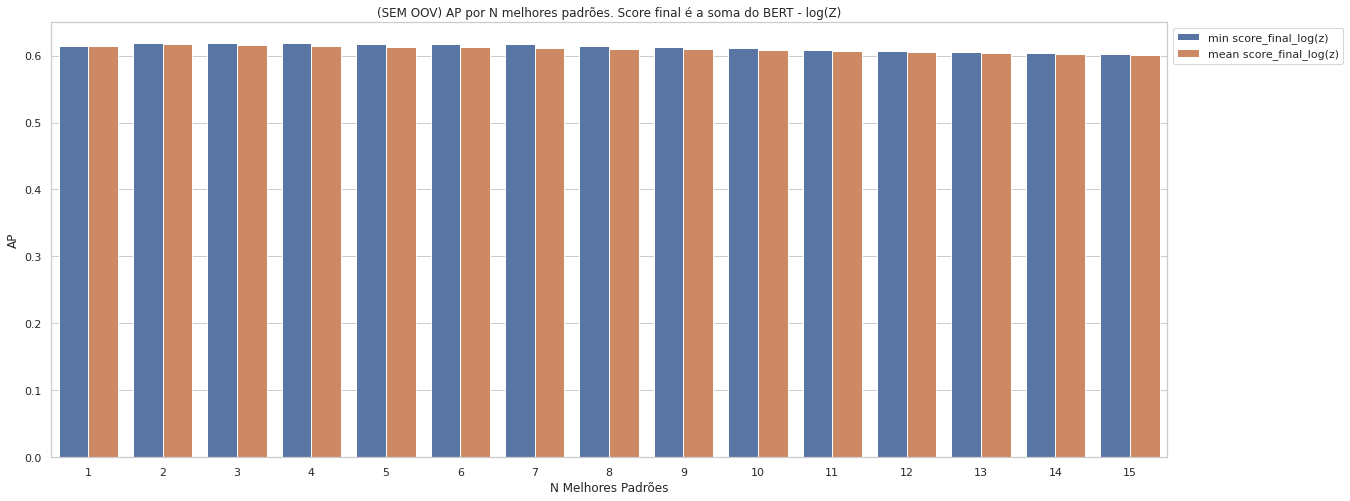

In [12]:
# AP por n-rank
df_plot = compute_AP_n_best_pattern(df_240, key_sort="score_final_log(z)", n_best_pattern=best_pattern_logz)
plt.figure(figsize=(20, 8))
ax = sns.barplot(data=df_plot, x='n_best_pattern', y='AP', hue='method')
ax.set(xlabel="N Melhores Padrões")
ax.set_title(f"(SEM OOV) AP por N melhores padrões. Score final é a soma do BERT - log(Z)")
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In [13]:
df_mean = df_plot[df_plot['method'] == 'mean score_final_log(z)']
df_mean = df_mean.sort_values(by='AP', ascending=False)
print(f"(SEM OOV) Melhor combinação de Padrões usando Média dos ranks entre eles")
print(df_mean.iloc[:4])

print(f"(SEM OOV) Melhor combinação de Padrões usando Minimo dos ranks entre eles")
df_min = df_plot[df_plot['method'] == 'min score_final_log(z)']
df_min = df_min.sort_values(by='AP', ascending=False)
print(df_min.iloc[:4])

(SEM OOV) Melhor combinação de Padrões usando Média dos ranks entre eles
   n_best_pattern                   method        AP
3               2  mean score_final_log(z)  0.616772
5               3  mean score_final_log(z)  0.615469
1               1  mean score_final_log(z)  0.614867
7               4  mean score_final_log(z)  0.614425
(SEM OOV) Melhor combinação de Padrões usando Minimo dos ranks entre eles
   n_best_pattern                  method        AP
4               3  min score_final_log(z)  0.618626
2               2  min score_final_log(z)  0.618578
6               4  min score_final_log(z)  0.618106
8               5  min score_final_log(z)  0.618013


In [14]:
# import itertools
# comb = []
# for i in range(1, len(pattern_unique) + 1):
#     comb.append(list(map(list, itertools.combinations(pattern_unique, r=i))))
# combinations = []
# for i in range(len(comb)):
#     combinations += comb[i]

# ap_comb = {'id': [], 'min_ap': [], 'mean_ap': []}
# for i in range(len(combinations)):
#     min_ap, mean_ap = compute_AP_by_rank(df_240, key_sort="score_final_log(z)", best_patterns=combinations[i])
#     ap_comb['id'].append(i)
#     ap_comb['min_ap'].append(min_ap)
#     ap_comb['mean_ap'].append(mean_ap)
# df_combination = pd.DataFrame(ap_comb)


------------------------------



-----------------------------

## Balanceamento do Dataset e AP por padrão
#### Wikipedia 240M com OOV (Usando todo o dataset)
 - N = 94446 pares

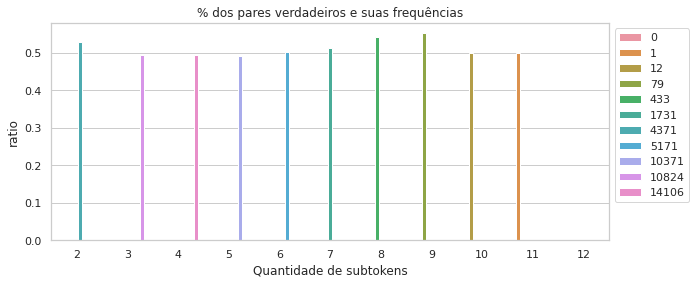

In [15]:
# Balanceamento df_with_oov
df_with_oov_ratio = balanceamento(df_with_oov, len_size=len_total_unique)

plt.figure(figsize=(10, 4))
ax = sns.barplot(x="len_total", y="ratio", hue="true", data=df_with_oov_ratio)
ax.set(xlabel="Quantidade de subtokens")
ax.set_title(f"% dos pares verdadeiros e suas frequências")
ax.legend(bbox_to_anchor=(1, 1))

_ = _

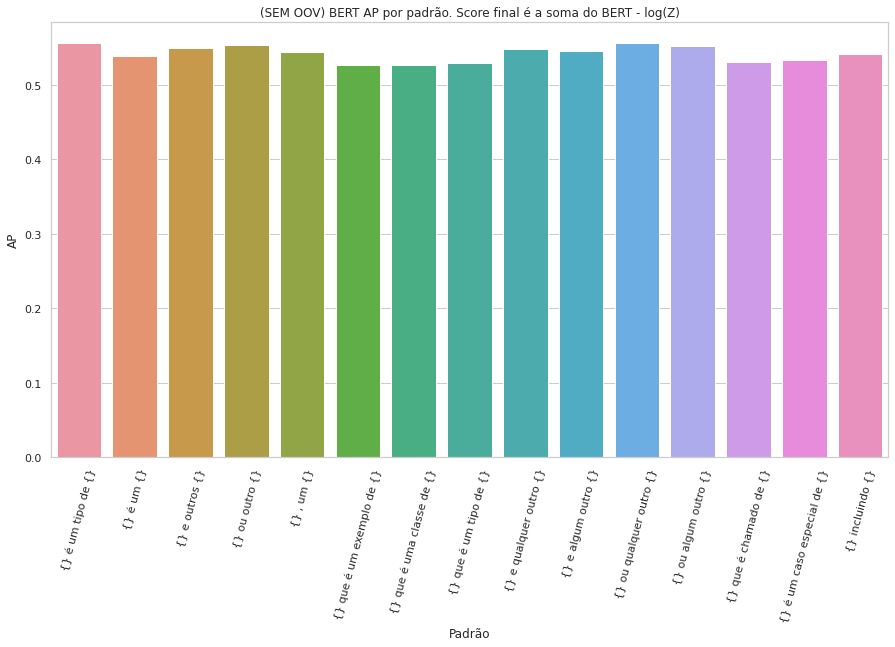

Melhores padrões usando score_final_log(Z)
['{} ou qualquer outro {}', '{} é um tipo de {}', '{} ou outro {}', '{} ou algum outro {}', '{} e outros {}', '{} e qualquer outro {}', '{} e algum outro {}', '{} , um {}', '{} incluindo {}', '{} é um {}', '{} é um caso especial de {}', '{} que é chamado de {}', '{} que é um tipo de {}', '{} que é um exemplo de {}', '{} que é uma classe de {}']


In [16]:
# AP por padrão
df_plot = compute_dataframe_AP_by_pattern(df_with_oov, key_sort="score_final_log(z)", pattern_list=pattern_unique)
plt.figure(figsize=(15, 8))
ax = sns.barplot(data=df_plot, x='padrao', y='AP')
ax.set(xlabel="Padrão")
ax.set_title(f"(SEM OOV) BERT AP por padrão. Score final é a soma do BERT - log(Z)")
plt.xticks(rotation=75)
plt.show()

print(f"Melhores padrões usando score_final_log(Z)")
best_pattern_logz = df_plot.sort_values(by='AP', ascending=False)['padrao'].tolist()
print(best_pattern_logz)


#### Wikipedia 240M com OOV
 - Size = 94446 pares
 - AP combinando os N melhores padrões
  > Cada par tem uma lista de rankings
  
   > Min Score - Usa o menor rank dessa lista
  
   > Mean Score - Usa a média dessa lista

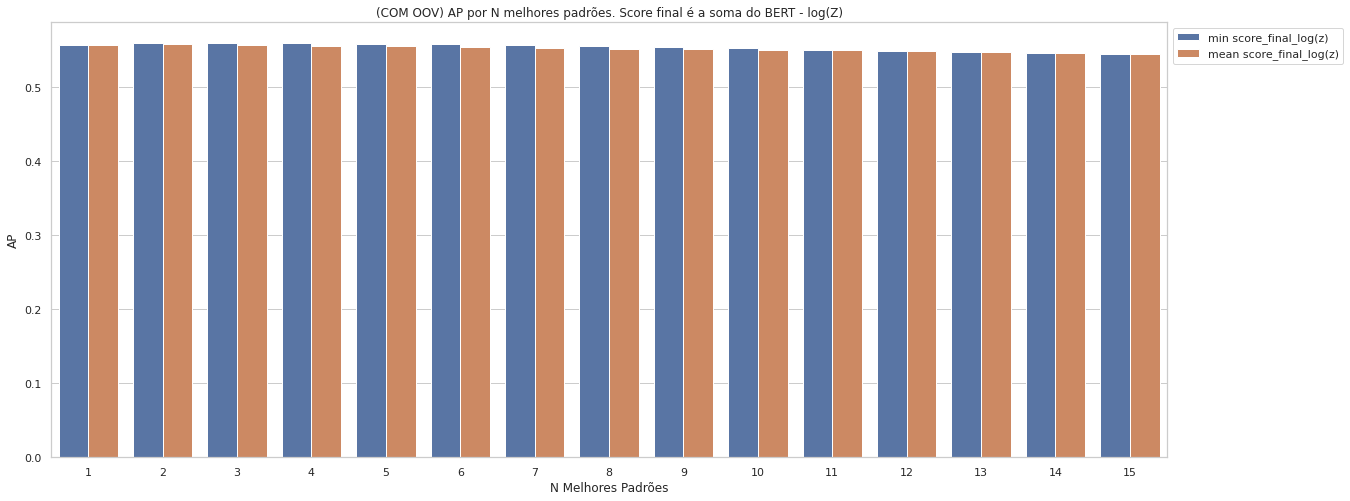

In [17]:
# AP por n-rank
df_plot = compute_AP_n_best_pattern(df_with_oov, key_sort="score_final_log(z)", n_best_pattern=best_pattern_logz)
plt.figure(figsize=(20, 8))
ax = sns.barplot(data=df_plot, x='n_best_pattern', y='AP', hue='method')
ax.set(xlabel="N Melhores Padrões")
ax.set_title(f"(COM OOV) AP por N melhores padrões. Score final é a soma do BERT - log(Z)")
ax.legend(bbox_to_anchor=(1, 1))
plt.show()

In [18]:
df_mean = df_plot[df_plot['method'] == 'mean score_final_log(z)']
df_mean = df_mean.sort_values(by='AP', ascending=False)
print(f"(COM OOV) Melhor combinação de Padrões usando Média dos ranks entre eles")
print(df_mean.iloc[:4])

print(f"(COM OOV) Melhor combinação de Padrões usando Minimo dos ranks entre eles")
df_min = df_plot[df_plot['method'] == 'min score_final_log(z)']
df_min = df_min.sort_values(by='AP', ascending=False)
print(df_min.iloc[:4])

(COM OOV) Melhor combinação de Padrões usando Média dos ranks entre eles
   n_best_pattern                   method        AP
3               2  mean score_final_log(z)  0.557288
5               3  mean score_final_log(z)  0.556178
1               1  mean score_final_log(z)  0.555868
7               4  mean score_final_log(z)  0.555246
(COM OOV) Melhor combinação de Padrões usando Minimo dos ranks entre eles
   n_best_pattern                  method        AP
4               3  min score_final_log(z)  0.558960
2               2  min score_final_log(z)  0.558936
6               4  min score_final_log(z)  0.558514
8               5  min score_final_log(z)  0.558157
